# Dependency Parsing Homework

## Nutdanai Sritunya st123055 MMI

In [1]:
import sys
import numpy as np
import time
import os
import logging
from collections import Counter
from datetime import datetime
import math

from tqdm import tqdm  #gimmick for progressbar when you train
import pickle #saving and loading models

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

## 1. Parsing function

We gonna start with a class `Parsing`, representing a parser for each sentence.  For each sentence, we need the `stack`, `buffer`, and the `dependencies`.

In [2]:
#basically, it takes the current state of the buffer, stack, dependencies
# #tell us how SHIFT, LA, RA changes these three objects

class Parsing(object):
    
    #init stack, buffer, dep
    def __init__(self, sentence):  
        self.sentence = sentence     #['The', 'cat', 'sat]  #conll format which is already in the tokenized form
        self.stack    = ['ROOT']
        self.buffer   = sentence[:]  #in the beginning, everything is inside the buffer
        self.dep      = []           #maintains a list of tuples of dep
    
    #parse function that tells me how shift, la, ra changes these three objects
    def parse_step(self, transition):     #transition could be either S, LA, RA
        if transition == 'S':
            #get the top guy in the buffer and put in stack
            head = self.buffer.pop(0)
            self.stack.append(head)
        elif transition == 'LA':  #stack = [ROOT, He, has] ==> append to dep (has, he) and then He is gone from the stack [ROOT, has]
            dependent = self.stack.pop(-2)  #He
            self.dep.append((self.stack[-1], dependent))  #(has, he)
        elif transition == 'RA':
            #can you guys try to this???
            dependent = self.stack.pop()  #stack = [ROOT, has, control] ==> dep (has, control), control will be gone fromt he stack [ROOT, has]
            self.dep.append((self.stack[-1], dependent))
        else:
            print(f"Bad transition: {transition}")
    
    #given some series of transition, it gonna for-loop the parse function
    def parse(self, transitions):
        for t in transitions:
            self.parse_step(t)
        return self.dep
    
    #check whether things are finished - no need to do anymore functions....
    def is_completed(self):
        return (len(self.buffer) == 0) and (len(self.stack) == 1)  #so buffer is empty and ROOT is the only guy in stack

### Minibatch parsing

We gonna create a minibatch loader that loads a bunch of sentences, and perform parse accordingly.  For now, we will assume a very dump model to predict the transitions.

In [8]:
def minibatch_parse(sentences, model, batch_size):
    dep = []  #all the resulting dep
    
    #init Parsing instance for each sentence in the batch
    partial_parses = [Parsing(sentence) for sentence in sentences]  #in tokenized form
    #Parsing(['The', 'cat', 'sat']), Parsing(['Chaky', 'is', 'mad'])
    
    unfinished_parses = partial_parses[:]
    
    #while we still have sentence
    while unfinished_parses:  #if there are still a Parsing object
    
        #take a certain batch of sentence
        minibatch = unfinished_parses[:batch_size] #number of Parsing object
        
        #create a dummy model to tell us what's the next transition for each sentence
        transitions = model.predict(minibatch) 
        #transitions = [S, S, .....]
        #minibatch   = [Parsing(sentence1), Parsing(sentence2)]
        
                
        # for transition predicted this dummy model
        for transition, partial_parse in zip(transitions, minibatch):
            #parse step
            #transition: S
            #partial_parse: Parsing(sentence)
            partial_parse.parse_step(transition)
            
        #remove any sentence is finish
        unfinished_parses[:] = [p for p in unfinished_parses if not p.is_completed()]
    
    dep = [parse.dep for parse in partial_parses]
    
    return dep

## 2. Load data

In [9]:
def read_conll(filename):
    
    examples = []
    
    with open(filename) as f:
        i = 0
        word, pos, head, dep = [], [], [], []
        for line in f.readlines():
            i = i+1
            wa = line.strip().split('\t')  #['1', 'In', '_', 'ADP', 'IN', '_', '5', 'case', '_', '_']
            #In <--------  5th guy
            #     case
            
            if len(wa) == 10:  #if all the columns are there
                word.append(wa[1].lower())
                pos.append(wa[4])
                head.append(int(wa[6]))
                dep.append(wa[7])
            
            #the row is not exactly 10, it means new sentence
            elif len(word) > 0:  #if there is somethign inside the word
                examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})  #in the sentence level
                word, pos, head, dep = [], [], [], [] #clear word, pos, head, dep
        
        if len(word) > 0:  #if there is somethign inside the word
            examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})  #in the sentence level

    return examples                

In [10]:
def load_data():
    print("1. Loading data")
    train_set = read_conll("data/train.conll")
    dev_set   = read_conll("data/dev.conll")
    test_set   = read_conll("data/test.conll")
    
    #make my dataset smaller because my mac cannot handle it
    train_set = train_set[:1000]
    dev_set   = dev_set[:500]
    test_set  = test_set[:500]
    
    return train_set, dev_set, test_set

### Testing the load function

In [11]:
train_set, dev_set, test_set = load_data()

1. Loading data


In [13]:
len(train_set), len(dev_set), len(test_set)

(1000, 500, 500)

To understand, we can draw these in a dependency tree, with the help of spaCy.  **Note** that spaCy do not draw the ROOT for us, but imagine the head of "plays" is ROOT.

In [14]:
#we eventually gonna make the dependency
#so maybe we can cheat a little bit, and see the answer

import spacy
from spacy import displacy #displacy is for visualization

nlp = spacy.load("en_core_web_sm")
doc = nlp("Ms. Haag plays Elianti .")
options = {"collapse_punct": False}

displacy.render(doc, options = options, style="dep", jupyter=True)

## 3. Parser

We gonna create a parser that gonna help us:
- create a `tok2id` dictionary in the `__init__` function
- numercalize `numercalize` the words, dependencies, and pos tags
- create training data, `create_instances` by leveraging the ground truth of the dependencies
- finally the `parse` function

This feature vector consists of a list of tokens. They can be represented as a list of integers $\mathbf{w} = [w_1, w_2, \cdots, w_m]$ where $m$ is the number of features and each $0 \leq w_i \leq |V|$ is the index of a token in the vocabulary ($|V|$ is the vocabulary size).  Then our network looks up an embedding for each word and concatenates them into a single input vector:

$$\mathbf{x} = [\mathbf{E}_{w_1}, \cdots, \mathbf{E}_{w_m}] \in \mathbb{R}^{dm}$$

where $\mathbf{E} \in \mathbb{R}^{|V| \times d}$ is an embedding matrix with each row $\mathbf{E}_w$ as the vector for a particular word $w$

#### Features

A total of 18 + 18 + 12 features were used in the paper.

- Feature 1: 18 features
  - (a). 6 - top 3 words on buffer, top 3 words on stack, 
  - (b). 6 - the first and second left most/rightmost children and the leftmost/rightmost of the **top word** (i.e., `stack[-1]`) on the stack,  - `(leftmost(0), rightmost(0), secondleftmost(0), secondrightmost(0), leftmost(leftmost(0)), rightmost(rightmost(0)))`
  - (c). 6 - the first and second left most/rightmost children and the leftmost/rightmost of the **second top word** (i.e., `stack[-2]`) on the stack, - `(leftmost(0), rightmost(0), secondleftmost(0), secondrightmost(0), leftmost(leftmost(0)), rightmost(rightmost(0)))`
- Feature 2: 18 pos - basically corresponding POS tags
- Feature 3: 12 dep - corresponding ARC, excluding 6 words on the stack/buffer..

**NOTE**: There is no 3a because each word itself does not have dependency

**NOTE**: For brevity, the table skipped 2b, 2c

**NOTE**: Here, in the dependency column, I used LABELED dependency.   But in my code, it is unlabeled, thus e.g., COMPOUND will not be needed.

| Stack | Buffer | Feature 1a | Feature 1b | Feature 1c | Feature 2a | Feature 3b | Feature 3c | Dependency (ARC) | Transition |
| :--   |  :--   | :--        | :--        | :--        | :--        | :--        | :--        | :--               | :--        |
| [ROOT] | [Ms., Haag, plays, Elianti, .] | [NULL, NULL, ROOT, Ms., Haag, plays] | [NULL, NULL, NULL, NULL, NULL, NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-NULL, P-NULL, P-ROOT, PROPN, PROPN, VERB] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]  | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]| | Init |
| [ROOT, Ms.] | [Haag, plays, Elianti, .] | [NULL, ROOT, Ms., Haag, plays, Elianti] | [NULL, NULL, NULL, NULL, NULL, NULL]  | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-NULL, P-ROOT, PROPN, PROPN, VERB, PROPN] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]  | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]| | SHIFT |
| [ROOT, Ms., Haag] | [plays, Elianti, .] | [ROOT, Ms., Haag, plays, Elianti, .] | [NULL, NULL, NULL, NULL, NULL, NULL]  | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-ROOT, PROPN, PROPN, VERB, PROPN, PUNCT] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]  | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL]|  | SHIFT |
| [ROOT, Haag] | [plays, Elianti, .] | [NULL, ROOT, Haag, plays, Elianti, .] | [Ms., NULL, NULL, NULL, NULL, NULL, NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-NULL, P-ROOT, PROPN, VERB, PROPN, PUNCT] | [COMPOUND, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | (Haag, Ms., COMPOUND) | LEFTARC |
| [ROOT, Haag, plays] | [Elianti, .] | [ROOT, Haag, plays, Elianti, ., NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [Ms., NULL, NULL, NULL, NULL, NULL] | [P-ROOT, PROPN, VERB, PROPN, PUNCT, P-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | [COMPOUND, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | (Haag, Ms., COMPOUND) | SHIFT |
| [ROOT, plays] | [Elianti, .] | [NULL, ROOT, plays, Elianti, ., NULL] | [Haag, NULL, NULL, NULL, Ms., NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-NULL, P-ROOT, VERB, PROPN, PUNCT, P-NULL] | [NSUBJ, D-NULL, D-NULL, D-NULL, COMPOUND, D-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ) | LEFTARC |
| [ROOT, plays, Elianti] | [.] | [ROOT, plays, Elianti, ., NULL, NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [Haag, NULL, NULL, NULL, Ms., NULL] | [P-ROOT, VERB, PROPN, PUNCT, P-NULL, P-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | [NSUBJ, D-NULL, D-NULL, D-NULL, COMPOUND, D-NULL] | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ) | SHIFT |
| [ROOT, plays] | [.] | [NULL, ROOT, plays, ., NULL, NULL] | [Haag, Elianti, NULL, NULL, Ms., NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [P-NULL, P-ROOT, VERB, PUNCT, P-NULL, P-NULL] | [NSUBJ, DOBJ, D-NULL, D-NULL, COMPOUND, D-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ), (plays, Elianti, DOBJ) | RIGHTARC |
| [ROOT, plays, .] | [] | [ROOT, plays, ., NULL, NULL, NULL] | [NULL, NULL, NULL, NULL, NULL, NULL] | [Haag, Elianti, NULL, NULL, Ms., NULL] | [P-NULL, P-ROOT, VERB, PUNCT, P-NULL, P-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | [NSUBJ, DOBJ, D-NULL, D-NULL, COMPOUND, D-NULL] | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ), (plays, Elianti, DOBJ) | SHIFT |
| [ROOT, plays] | [] | [NULL, ROOT, plays, NULL, NULL, NULL] | [Haag, Elianti, NULL, plays, Ms., NULL] | [Haag, Elianti, NULL, NULL, Ms., NULL] | [P-NULL, P-ROOT, VERB, P-NULL, P-NULL, P-NULL] | [NSUBJ, PUNCT, D-NULL, DOBJ, COMPOUND, D-NULL] | [D-NULL, D-NULL, D-NULL, D-NULL, D-NULL, D-NULL] | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ), (plays, Elianti, DOBJ), (plays, ., PUNCT) | RIGHT-ARC |
| [ROOT] | [] |  | |  |  |  |  | (Haag, Ms., COMPOUND), (plays, Haag, NSUBJ), (plays, Elianti, DOBJ), (plays, ., PUNCT), (ROOT, plays, ROOT) | RIGHT-ARC |

In [15]:
P_PREFIX = '<p>:' #indicating pos tags
D_PREFIX = '<d>:' #indicating dependency tags
UNK      = '<UNK>'
NULL     = '<NULL>'
ROOT     = '<ROOT>'

class Parser(object):

    def __init__(self, dataset, dep_logi=True, pos_logi=True):
        
        #set the root dep
        self.root_dep = 'root'
        self.dep_logi = dep_logi
        self.pos_logi = pos_logi
                
        #get all the dep of the dataset as list, e.g., ['root', 'acl', 'nmod', 'nmod:npmod']
        all_dep = [self.root_dep] + list(set([w for ex in dataset
                                               for w in ex['dep']
                                               if w != self.root_dep]))
        
        #1. put dep into tok2id lookup table, with D_PREFIX so we know it is dependency
        #{'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'D_PREFIX:<NULL>': 30}
        tok2id = {D_PREFIX + l: i for (i, l) in enumerate(all_dep)}
        tok2id[D_PREFIX + NULL] = self.D_NULL = len(tok2id)
        
        #we are using "unlabeled" where we do not label with the dependency
        #thus the number of dependency relation is 1
        trans = ['L', 'R', 'S']
        self.n_deprel = 1   #because we are not predicting the relations, we are only predicting S, L, R
        # self.n_features = 0
        #create a simple lookup table mapping action and id
        #e.g., tran2id: {'L': 0, 'R': 1, 'S': 2}
        #e.g., id2tran: {0: 'L', 1: 'R', 2: 'S'}
        self.n_trans = len(trans)
        self.tran2id = {t: i for (i, t) in enumerate(trans)}  #use for easy coding
        self.id2tran = {i: t for (i, t) in enumerate(trans)}
        print(self.dep_logi)
        print(self.pos_logi)
        #2. put pos tags into tok2id lookup table, with P_PREFIX so we know it is pos
        tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                  offset=len(tok2id)))
        tok2id[P_PREFIX + UNK]  = self.P_UNK  = len(tok2id)  #also remember the pos tags of unknown
        tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
        tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)
        
        #now tok2id:  {'P_PREFIX:root': 0, 'P_PREFIX:acl': 1, ..., 'P_PREFIX:JJR': 62, 'P_PREFIX:<UNK>': 63, 'P_PREFIX:<NULL>': 64, 'P_PREFIX:<ROOT>': 65}
        
        #3. put word into tok2id lookup table
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK]  = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)
        
        #now tok2id: {'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'memory': 340, 'mr.': 341, '<UNK>': 342, '<NULL>': 343, '<ROOT>': 344}
        # self.n_features = 0
        #create id2tok
        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}
        if self.dep_logi == True and self.pos_logi == True :
            self.n_features = 18 + 18 + 12
        elif self.dep_logi == True and self.pos_logi == False :
            self.n_features = 18 + 12
        elif self.dep_logi == False and self.pos_logi == True :
            self.n_features = 18 + 18
        else :
            pass
        self.n_tokens = len(tok2id)
        print(self.n_features)
        
    #utility function, in case we want to convert token to id
    #function to turn train set with words to train set with id instead using tok2id
    def numericalize(self, examples):
        numer_examples = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]
            pos  = [self.P_ROOT] + [self.tok2id[P_PREFIX + w] if P_PREFIX + w in self.tok2id
                                   else self.P_UNK for w in ex['pos']]
            head = [-1] + ex['head']
            dep  = [-1] + [self.tok2id[D_PREFIX + w] if D_PREFIX + w in self.tok2id
                            else -1 for w in ex['dep']]
            numer_examples.append({'word': word, 'pos': pos,
                                 'head': head, 'dep': dep})
        return numer_examples
    
    #function to extract features to form a feature embedding matrix
    def extract_features(self, stack, buf, arcs, ex):
             
        #ex['word']:  [55, 32, 33, 34, 35, 30], i.e., ['root', 'ms.', 'haag', 'plays', 'elianti', '.']
        #ex['pos']:   [29, 14, 14, 16, 14, 17], i.e., ['NNP', 'NNP', 'VBZ', 'NNP', '.']
        #ex['head']:  [-1, 2, 3, 0, 3, 3]  or ['root', 'compound', 'nsubj', 'root', 'dobj', 'punct']}
        #ex['dep']:   [-1, 1, 2, 0, 6, 12] or ['compound', 'nsubj', 'root', 'dobj', 'punct']

        #stack     :  [0]
        #buffer    :  [1, 2, 3, 4, 5]
        
        if stack[0] == "ROOT":
            stack[0] = 0  #start the stack with [ROOT]
            
        p_features = [] #pos features (2a, 2b, 2c) - 18
        d_features = [] #dep features (3b, 3c) - 12
        
        #last 3 things on the stack as features
        #if the stack is less than 3, then we simply append NULL from the left
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        
        # next 3 things on the buffer as features
        #if the buffer is less than 3, simply append NULL
        #the reason why NULL is appended on end because buffer is read left to right
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        
        #corresponding pos tags
        p_features = [self.P_NULL] * (3 - len(stack)) + [ex['pos'][x] for x in stack[-3:]]
        p_features += [ex['pos'][x] for x in buf[:3]] + [self.P_NULL] * (3 - len(buf))
        
        #get leftmost children based on the dependency arcs
        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        #get right most children based on the dependency arcs
        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)
        
        #get the leftmost and rightmost children of the top two words, thus we loop 2 times
        for i in range(2):
            if i < len(stack):
                k = stack[-i-1] #-1, -2 last two in the stack
                
                #the first and second lefmost/rightmost children of the top two words (i=1, 2) on the stack
                lc = get_lc(k)  
                rc = get_rc(k)
                
                #the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack:
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                #(leftmost of first word on stack, rightmost of first word, 
                # leftmost of the second word on stack, rightmost of second, 
                # leftmost of leftmost, rightmost of rightmost
                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)

                #corresponding pos
                p_features.append(ex['pos'][lc[0]] if len(lc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rc[0]] if len(rc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][lc[1]] if len(lc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][rc[1]] if len(rc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][llc[0]] if len(llc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rrc[0]] if len(rrc) > 0 else self.P_NULL)
            
                #corresponding dep
                d_features.append(ex['dep'][lc[0]] if len(lc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rc[0]] if len(rc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][lc[1]] if len(lc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][rc[1]] if len(rc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][llc[0]] if len(llc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rrc[0]] if len(rrc) > 0 else self.D_NULL)
                
            else:
                #attach NULL when they don't exist
                features += [self.NULL] * 6
                p_features += [self.P_NULL] * 6
                d_features += [self.D_NULL] * 6
        if self.dep_logi == True and self.pos_logi == True :
            features += p_features + d_features
        elif self.dep_logi == True and self.pos_logi == False :
            features += d_features
        elif self.dep_logi == False and self.pos_logi == True :
            features += p_features
        else :
            pass         
        
        assert len(features) == self.n_features
        
        return features

    #generate training examples
    #from the training sentences and their gold parse trees 
    def create_instances(self, examples):  #examples = word, pos, head, dep
        all_instances = []
        
        for i, ex in enumerate(examples):
            #Ms. Haag plays Elianti .
            #e.g., ex['word]: [344, 163, 99, 164, 165, 68]
            #here 344 stands for ROOT
            #Chaky - I cheated and take a look
            n_words = len(ex['word']) - 1  #excluding the root
            
            #arcs = {(head, tail, dependency label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]  #[1, 2, 3, 4, 5]
            arcs = []
            instances = []
            
            #because that's the maximum number of shift, leftarcs, rightarcs you can have
            #this will determine the sample size of each training example
            #if given five words, we will get a sample of (10, 48) where 10 comes from 5 * 2, and 48 is n_features
            #but this for loop can be break if there is nothing left....
            for i in range(n_words * 2):  #maximum times you can do either S, L, R
                
                #get the gold transition based on the parse trees
                #gold_t can be either shift(2), leftarc(0), or rightarc(1)
                gold_t = self.get_oracle(stack, buf, ex)
                
                #if gold_t is None, no need to extract features.....
                if gold_t is None:
                    break
                
                #make sure when the model predicts, we inform the current state of stack and buffer, so
                #the model is not allowed to make any illegal action, e.g., buffer is empty but trying to pop
                legal_labels = self.legal_labels(stack, buf)                
                assert legal_labels[gold_t] == 1
                
                #extract all the 48 features 
                features = self.extract_features(stack, buf, arcs, ex)
                instances.append((features, legal_labels, gold_t))
                
                #shift 
                if gold_t == 2:
                    stack.append(buf[0])
                    buf = buf[1:]
                #left arc 
                elif gold_t == 0:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                #right arc
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
                    
            else:
                all_instances += instances

        return all_instances
    
    #provide an one hot encoding of the labels
    def legal_labels(self, stack, buf):
        labels =  ([1] if len(stack) > 2  else [0]) * self.n_deprel  #left arc but you cannot do ROOT <--- He
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel  #right arc because ROOT --> He
        labels += [1] if len(buf) > 0 else [0]  #shift
        return labels
    
    #a simple function to check punctuation POS tags
    def punct(self, pos):
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]
    
    #decide whether to shift, leftarc, or rightarc, based on gold parse trees
    #this is needed to create training examples which contain samples and ground truth
    def get_oracle(self, stack, buf, ex):
        
        #leave if the stack is only 1, thus nothing to predict....
        if len(stack) < 2:
            return self.n_trans - 1
        
        #predict based on the last two words on the stack
        #stack: [ROOT, he, has]
        i0 = stack[-1] #has
        i1 = stack[-2] #he
        
        #get the head and dependency
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]
        d0 = ex['dep'][i0]
        d1 = ex['dep'][i1]
        
        #either shift, left arc or right arc
        #"Shift" = 2; "LA" = 0; "RA" = 1
        #if head of the second last word is the last word, then leftarc
        if (i1 > 0) and (h1 == i0):
            return 0  #action is left arc ---> gold_t
        #if head of the last word is the second last word, then rightarc
        #make sure nothing in the buffer has head with the last word on the stack
        #otherwise, we lose the last word.....
        elif (i1 >= 0) and (h0 == i1) and \
                (not any([x for x in buf if ex['head'][x] == i0])):
            return 1  #right arc
        #otherwise shift, if something is left in buffer, otherwise, do nothing....
        else:
            return None if len(buf) == 0 else 2  #shift
        
    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
        
        for i, example in enumerate(dataset):
            
            #example['word']=[188, 186, 186, ..., 59]
            #n_words=37
            #sentence=[1, 2, 3, 4, 5,.., 37]
            
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]            
            sentences.append(sentence)
            
            #mapping the object unique id to the i            
            #The id is the object's memory address
            sentence_id_to_idx[id(sentence)] = i
            
        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)
        
        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                for pred_h, gold_h, gold_l, pos in \
                        zip(head[1:], ex['head'][1:], ex['dep'][1:], ex['pos'][1:]):
                        assert self.id2tok[pos].startswith(P_PREFIX)
                        pos_str = self.id2tok[pos][len(P_PREFIX):]
                        if (not self.punct(pos_str)):
                            UAS += 1 if pred_h == gold_h else 0
                            all_tokens += 1
                prog.update(i + 1)
        UAS /= all_tokens
        return UAS, dependencies
    # def num_feature(self) :
    #     return self.n_features  


In [16]:
class ModelWrapper(object):
    def __init__(self, parser, dataset, sentence_id_to_idx):
        self.parser = parser
        self.dataset = dataset
        self.sentence_id_to_idx = sentence_id_to_idx

    def predict(self, partial_parses):
        mb_x = [self.parser.extract_features(p.stack, p.buffer, p.dep,
                                             self.dataset[self.sentence_id_to_idx[id(p.sentence)]])
                for p in partial_parses]
        mb_x = np.array(mb_x).astype('int32')
        mb_x = torch.from_numpy(mb_x).long()
        mb_l = [self.parser.legal_labels(p.stack, p.buffer) for p in partial_parses]

        pred = self.parser.model(mb_x)
        pred = pred.detach().numpy()
        
        #we need to multiply 10000 with legal labels, to force the model not to make any impossible prediction
        #other, when we parse sequentially, sometimes there is nothing in the buffer or stack, thus error....        
        pred = np.argmax(pred + 10000 * np.array(mb_l).astype('float32'), 1)
        pred = ["S" if p == 2 else ("LA" if p == 0 else "RA") for p in pred]
        
        return pred

In [17]:
#a simple function to create ids.....
def build_dict(keys, offset=0):
    #keys = ['P_PREFIX:IN', 'P_PREFIX:DT', 'P_PREFIX:NNP', 'P_PREFIX:CD', so on...]
    #offset is needed because this tok2id has something already inside....
    count = Counter()
    for key in keys:
        count[key] += 1
    
    #most_common = [('P_PREFIX:NN', 70), ('P_PREFIX:IN', 57), ... , ('P_PREFIX:JJR', 1)]
    #we use most_common in case we only want some maximum pos tags....
    mc = count.most_common()
    
    #{'P_PREFIX:NN': 31, 'P_PREFIX:IN': 32, .., 'P_PREFIX:JJR': 62} 
    return {w[0]: index + offset for (index, w) in enumerate(mc)}

### Testing the parser `__init__`

In [18]:
print("2. Building parser")
start = time.time()
parser_full = Parser(train_set, dep_logi=True, pos_logi = True)
print("took {:.2f} seconds".format(time.time() - start))

2. Building parser
True
True
48
took 0.03 seconds


### Testing the `numericalize`

In [19]:
#before numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])


Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:  ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:  ['compound', 'nsubj', 'root', 'dobj', 'punct']


In [20]:
train_set_n = parser_full.numericalize(train_set)
dev_set_n   = parser_full.numericalize(dev_set)
test_set_n  = parser_full.numericalize(test_set)

In [21]:
#before numericalize
print("Word: ", train_set_n[1]["word"])
print("Pos: ",  train_set_n[1]["pos"])
print("Head: ", train_set_n[1]["head"])
print("Dep: ",  train_set_n[1]["dep"])

Word:  [5156, 304, 1364, 1002, 2144, 87]
Pos:  [84, 42, 42, 55, 42, 46]
Head:  [-1, 2, 3, 0, 3, 3]
Dep:  [-1, 2, 22, 0, 9, 31]


## 4. Word Embedding

Word embedding length of 50.  In the paper, they applied a custom 50-embedding to all the words, pos, and dependencies.  For pos and dependencies, they claimed that there are some similarities that can be learned as well.

In [22]:
def Chaky_embeddings(parsers) :    
    print("4. Loading pretrained embeddings...",)
    start = time.time()
    word_vectors = {}
    for line in open("data/en-cw.txt").readlines():
        we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
        word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
        
    #create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
    #we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
    embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parsers.n_tokens, 50)), dtype='float32')

    for token in parsers.tok2id:
            i = parsers.tok2id[token]
            if token in word_vectors:
                embeddings_matrix[i] = word_vectors[token]
            elif token.lower() in word_vectors:
                embeddings_matrix[i] = word_vectors[token.lower()]
    print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
    print("took {:.2f} seconds".format(time.time() - start))
    return embeddings_matrix
  

In [23]:
embeddings_matrix_full = Chaky_embeddings(parser_full)  

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 3.05 seconds


In [24]:
len(embeddings_matrix_full)

5157

## 5. Preprocessing

In [25]:
print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser_full.create_instances(train_set_n)
print("took {:.2f} seconds".format(time.time() - start))

5. Preprocessing training data...
took 1.20 seconds


In [26]:
train_examples[0][0][:5] #features, legal_labels, transition

[5155, 5155, 5156, 91, 113]

## 6. Minibatch loader

In [27]:
def get_minibatches(data, minibatch_size, shuffle=True):
    data_size = len(data[0])
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield [_minibatch(d, minibatch_indices) for d in data]

def _minibatch(data, minibatch_idx):
    return data[minibatch_idx] if type(data) is np.ndarray else [data[i] for i in minibatch_idx]

def minibatches(data, batch_size):
    x = np.array([d[0] for d in data])
    y = np.array([d[2] for d in data])
    one_hot = np.zeros((y.size, 3))
    one_hot[np.arange(y.size), y] = 1
    return get_minibatches([x, one_hot], batch_size)

## 7. Neural Network



In [29]:
class ParserModel(nn.Module):

    def __init__(self, embeddings, n_features=48,
                 hidden_size=400, n_classes=3, dropout_prob=0.5):

        super(ParserModel, self).__init__()
        self.n_features   = n_features
        self.n_classes    = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size   = embeddings.shape[1]
        self.hidden_size  = hidden_size
        self.pretrained_embeddings = nn.Embedding(embeddings.shape[0], self.embed_size)
        self.pretrained_embeddings.weight = nn.Parameter(torch.tensor(embeddings))

        self.embed_to_hidden = nn.Linear(n_features * self.embed_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.hidden_to_logits = nn.Linear(hidden_size, n_classes)

    def embedding_lookup(self, t):
        #t:  batch_size, n_features
        batch_size = t.size()[0]
                    
        x = self.pretrained_embeddings(t)        
        x = x.reshape(-1, self.n_features * self.embed_size)
        # x = (1024, 48 * 50)

        return x

    def forward(self, t):
        # t: (1024, 48)
        embeddings = self.embedding_lookup(t)  
    
        # embeddings: (1024, 48 * 50)
        hidden = self.embed_to_hidden(embeddings)
    
        # hidden: (1024, 200)
        hidden_activations = F.relu(hidden)
        # hidden_activations: (1024, 200)
        thin_net = self.dropout(hidden_activations)
        # thin_net: (1024, 200)
        logits = self.hidden_to_logits(thin_net)
        # logits: (1024, 3)

        return logits

Now let's code the <code>train_for_epoch</code> and <code>train</code> functions to actually train the model.

In [30]:
#just a class to get the average.....
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [31]:
def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005):
    
    best_dev_UAS = 0
    
    optimizer = optim.Adam(parser.model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size):
    
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
            
            #train_x:  batch_size, n_features
            #train_y:  batch_size, target(=3)
            
            optimizer.zero_grad() 
            loss = 0.
            train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

            # Forward pass: compute predicted logits.
            logits = parser.model(train_x)
            # Compute loss
            loss = loss_func(logits, train_y)
            # Compute gradients of the loss w.r.t model parameters.
            loss.backward()
            # Take step with optimizer.
            optimizer.step()

            prog.update(1)
            loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))
    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
        
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

## 8. Training

In [32]:
#create directory if it does not exist for saving the weights...
output_dir = "output/full/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model_full = ParserModel(embeddings_matrix_full, n_features=48)
parser_full.model = model_full

start = time.time()
train(parser_full, train_examples, dev_set_n, output_path,
      batch_size=1024, n_epochs=5, lr=0.0005)

TRAINING
Epoch 1 out of 5


100%|██████████| 48/48 [00:06<00:00,  7.43it/s]


Average Train Loss: 0.5092427898198366
Evaluating on dev set


125250it [00:00, 7828109.14it/s]       


- dev UAS: 56.93
New best dev UAS! Saving model.

Epoch 2 out of 5


100%|██████████| 48/48 [00:07<00:00,  6.80it/s]


Average Train Loss: 0.2893778368209799
Evaluating on dev set


125250it [00:00, 7827875.85it/s]       


- dev UAS: 64.55
New best dev UAS! Saving model.

Epoch 3 out of 5


100%|██████████| 48/48 [00:07<00:00,  6.73it/s]


Average Train Loss: 0.22973409884919724
Evaluating on dev set


125250it [00:00, 8349808.89it/s]       


- dev UAS: 67.17
New best dev UAS! Saving model.

Epoch 4 out of 5


100%|██████████| 48/48 [00:07<00:00,  6.00it/s]


Average Train Loss: 0.19704500461618105
Evaluating on dev set


125250it [00:00, 7828575.75it/s]       


- dev UAS: 68.66
New best dev UAS! Saving model.

Epoch 5 out of 5


100%|██████████| 48/48 [00:07<00:00,  6.32it/s]


Average Train Loss: 0.17327050399035215
Evaluating on dev set


125250it [00:00, 5963566.95it/s]       

- dev UAS: 71.48
New best dev UAS! Saving model.



## 9. Testing

In [33]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser_full.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser_full.model.eval()
UAS, dependencies = parser_full.parse(test_set_n)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6959114.26it/s]       

- test UAS: 72.56
Done!


# Ablation Study
* Try to delete only the 12 dep features and check UAS
* Try to delete only the 18 pos features and check UAS

<br>experiment
- what i do is add `dep_logi` and `pos_logi` at Paser object and when you set `dep_logi = False` 12 dep feature will deleted also when you set `pos_logi = False` <br>18 pos feature will deleted.

## 1.Try to delete only the 12 dep features and check UAS

In [34]:
print("2. Building parser")
start = time.time()
parser_no_dep = Parser(train_set, dep_logi=False, pos_logi = True)
print("took {:.2f} seconds".format(time.time() - start))

2. Building parser
False
True
36
took 0.04 seconds


In [35]:
train_set_n = parser_no_dep.numericalize(train_set)
dev_set_n   = parser_no_dep.numericalize(dev_set)
test_set_n  = parser_no_dep.numericalize(test_set)

In [36]:
embeddings_matrix_no_dep = Chaky_embeddings(parser_no_dep) 

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 3.15 seconds


In [37]:
print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser_no_dep.create_instances(train_set_n)
print("took {:.2f} seconds".format(time.time() - start))

5. Preprocessing training data...
took 1.32 seconds


In [38]:
#create directory if it does not exist for saving the weights...
output_dir = "output/no_dep/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model2 = ParserModel(embeddings_matrix_no_dep, n_features=36)
parser_no_dep.model = model2

start = time.time()
train(parser_no_dep, train_examples, dev_set_n, output_path,
      batch_size=1024, n_epochs=5, lr=0.0005)

TRAINING
Epoch 1 out of 5


100%|██████████| 48/48 [00:06<00:00,  7.89it/s]


Average Train Loss: 0.4952230869481961
Evaluating on dev set


125250it [00:00, 6592665.82it/s]       


- dev UAS: 59.63
New best dev UAS! Saving model.

Epoch 2 out of 5


100%|██████████| 48/48 [00:05<00:00,  8.12it/s]


Average Train Loss: 0.266220363167425
Evaluating on dev set


125250it [00:00, 6958376.84it/s]       


- dev UAS: 63.95
New best dev UAS! Saving model.

Epoch 3 out of 5


100%|██████████| 48/48 [00:05<00:00,  8.20it/s]


Average Train Loss: 0.21479015549023947
Evaluating on dev set


125250it [00:00, 7826942.83it/s]       


- dev UAS: 67.12
New best dev UAS! Saving model.

Epoch 4 out of 5


100%|██████████| 48/48 [00:05<00:00,  8.17it/s]


Average Train Loss: 0.17928949277848005
Evaluating on dev set


125250it [00:00, 7366527.97it/s]       


- dev UAS: 70.70
New best dev UAS! Saving model.

Epoch 5 out of 5


100%|██████████| 48/48 [00:05<00:00,  8.30it/s]


Average Train Loss: 0.1558153689838946
Evaluating on dev set


125250it [00:00, 7368077.76it/s]       

- dev UAS: 71.83
New best dev UAS! Saving model.



## Testing

Testing UAS of test set when delete 12 dep feature

In [39]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser_no_dep.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser_no_dep.model.eval()
UAS_no_dep, dependencies = parser_no_dep.parse(test_set_n)
print("- test UAS: {:.2f}".format(UAS_no_dep * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6958192.51it/s]       

- test UAS: 74.10
Done!


## 2.Try to delete only the 18 pos features and check UAS

In [40]:
print("2. Building parser")
start = time.time()
parser_no_pos = Parser(train_set, dep_logi=True, pos_logi = False)
print("took {:.2f} seconds".format(time.time() - start))

2. Building parser
True
False
30
took 0.05 seconds


In [41]:
train_set_n = parser_no_pos.numericalize(train_set)
dev_set_n   = parser_no_pos.numericalize(dev_set)
test_set_n  = parser_no_pos.numericalize(test_set)

In [42]:
embeddings_matrix_no_pos = Chaky_embeddings(parser_no_pos)

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 3.90 seconds


In [43]:
print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser_no_pos.create_instances(train_set_n)
print("took {:.2f} seconds".format(time.time() - start))

5. Preprocessing training data...
took 0.99 seconds


In [44]:
#create directory if it does not exist for saving the weights...
output_dir = "output/no_pos/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")

model = ParserModel(embeddings_matrix_no_pos, n_features=30)
parser_no_pos.model = model

start = time.time()
train(parser_no_pos, train_examples, dev_set_n, output_path,
      batch_size=1024, n_epochs=5, lr=0.0005)

TRAINING
Epoch 1 out of 5


100%|██████████| 48/48 [00:04<00:00,  9.72it/s]


Average Train Loss: 0.6355643688390652
Evaluating on dev set


125250it [00:00, 7367457.77it/s]       


- dev UAS: 51.82
New best dev UAS! Saving model.

Epoch 2 out of 5


100%|██████████| 48/48 [00:05<00:00,  8.67it/s]


Average Train Loss: 0.3443399810542663
Evaluating on dev set


125250it [00:00, 5692422.29it/s]       


- dev UAS: 58.00
New best dev UAS! Saving model.

Epoch 3 out of 5


100%|██████████| 48/48 [00:05<00:00,  8.16it/s]


Average Train Loss: 0.27830755307028693
Evaluating on dev set


125250it [00:00, 5963499.25it/s]       


- dev UAS: 61.56
New best dev UAS! Saving model.

Epoch 4 out of 5


100%|██████████| 48/48 [00:05<00:00,  8.59it/s]


Average Train Loss: 0.24064521801968417
Evaluating on dev set


125250it [00:00, 6958469.00it/s]       


- dev UAS: 63.90
New best dev UAS! Saving model.

Epoch 5 out of 5


100%|██████████| 48/48 [00:05<00:00,  9.03it/s]


Average Train Loss: 0.21427006584902605
Evaluating on dev set


125250it [00:00, 6591838.58it/s]       

- dev UAS: 66.72
New best dev UAS! Saving model.



## Testing

In [45]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser_no_pos.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser_no_pos.model.eval()
UAS_no_pos, dependencies = parser_no_pos.parse(test_set_n)
print("- test UAS: {:.2f}".format(UAS_no_pos * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6957271.00it/s]       

- test UAS: 67.62
Done!


|dataset| UAS (dep, pos) |  UAS (pos) | UAS (sep) |
|:-- | :--:   |  :--:          | :--:        |
|<b>dev_set| 71.48 | 71.83 |  66.72  | 
|<b>test_set| 72.56 | 74.10 |  67.62  | 



#  Chaky embedding vs GloVe 



## GloVe

### 1.Load the data

In [46]:
train_set, dev_set, test_set = load_data()

1. Loading data


In [47]:
train_set[1]  # this is what train set look like.

{'word': ['ms.', 'haag', 'plays', 'elianti', '.'],
 'pos': ['NNP', 'NNP', 'VBZ', 'NNP', '.'],
 'head': [2, 3, 0, 3, 3],
 'dep': ['compound', 'nsubj', 'root', 'dobj', 'punct']}

In [48]:
# create the list of word in key dict "word"
corpus = []
for word in train_set :
     corpus.append(word["word"])

In [49]:
corpus[1]

['ms.', 'haag', 'plays', 'elianti', '.']

In [50]:
flatten = lambda l: [item for sublist in l for item in sublist] # use the flatten and vocab code that provide in class
vocab = list(set(flatten(corpus))) #got a vocabs of each word
vocab[0:10]

['links',
 'exquisite',
 'good',
 'accomplished',
 'which',
 'cheer',
 're-elected',
 'sees',
 'pilgrim',
 'last-minute']

In [51]:
len(vocab)

5069

### 2.Numericalization

In [52]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
voc_size = len(vocab)

In [53]:
word2index['<UNK>'] = 0

In [54]:
word2index['policy']

951

### 3.Co occorence matrix

In [55]:
from collections import Counter
X_i = Counter(flatten(corpus)) # X_i

In [56]:
skip_grams = []
# loop each word sequence
# we starts from 1 because 0 has no context
# we stop at second last for the same reason
for sent in corpus:
    for i in range(1, len(sent) - 1):
        target = sent[i]
        context = [sent[i - 1], sent[i + 1]]
        for w in context:
            skip_grams.append((target, w))

skip_grams[0:5]

[('an', 'in'), ('an', 'oct.'), ('oct.', 'an'), ('oct.', '19'), ('19', 'oct.')]

In [57]:
len(skip_grams)

44720

In [58]:
X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 1

### 4.Weighting function

In [59]:
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1, basically smoothing technique
                
    x_max = 100  # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75 # Followed Chaky way!
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [60]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)
# 
# print(f"{X_ik=}")
# print(f"{weighting_dic=}")

### 5.prepare data

In [61]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### 6. model

In [62]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

### 7.training

In [63]:
batch_size     = 10 # mini-batch size
embedding_size = 50 #so we can later plot
model_glove          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [64]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [65]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model_glove(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 140.083832 | time: 0m 0s
Epoch: 2000 | cost: 23.872330 | time: 0m 0s
Epoch: 3000 | cost: 32.689800 | time: 0m 0s
Epoch: 4000 | cost: 38.512352 | time: 0m 0s
Epoch: 5000 | cost: 55.116276 | time: 0m 0s


In [66]:
def get_embed(word, model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] 
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_v(word)+model.embedding_u(word))/2
    return np.array(embed[0].detach().cpu().numpy())

In [67]:
get_embed("car",model_glove)

array([-1.1417243 ,  0.6116885 , -0.5726211 , -0.950994  ,  1.0880558 ,
        0.42978895, -1.225419  , -0.5943497 ,  0.03167275, -1.3596511 ,
        0.84988153,  0.01764725,  0.17927963,  0.28343362, -0.4388604 ,
       -0.58948934, -1.8111966 , -0.4000938 ,  0.4279513 ,  0.90014774,
       -0.26865658, -0.2200745 , -0.03649171, -0.92374563, -0.70100963,
        0.20497283, -0.49095508, -0.6991694 ,  0.02387497, -1.2568505 ,
       -0.40891427, -0.7243005 ,  1.2203032 ,  0.38824025, -0.3812165 ,
       -1.4482265 , -0.01481587, -0.27479246, -1.348225  ,  1.0349519 ,
       -0.27827185,  0.9703293 ,  1.4579797 , -0.52524126,  0.778848  ,
       -1.4880941 ,  0.55404437,  0.08982959, -0.372473  ,  0.68385375],
      dtype=float32)

# Comparison

## 1.Spacy

load the test data 

In [80]:
_, _, test_set = load_data()
# 1. Loading data

test_sentence = []
for word in test_set :
     test_sentence.append(word["word"])
test_sentence_1 = " ".join(test_sentence[16])
test_sentence_2 = " ".join(test_sentence[20]) 
test_dataset = [test_sentence_1,test_sentence_2]

1. Loading data


In [81]:
print(test_sentence_1)
print(test_sentence_2)

at the end of the day , 251.2 million shares were traded .
the dow fell 22.6 % on black monday .


In [82]:
import spacy
from spacy import displacy 
nlp = spacy.load("en_core_web_md")

for sent in test_dataset:
    doc = nlp(sent)
    options = {"collapse_punct": False}
    displacy.render(doc, options = options, style="dep", jupyter=True)

# 2.Our model

In [83]:
parser_full.model.eval

<bound method Module.eval of ParserModel(
  (pretrained_embeddings): Embedding(5157, 50)
  (embed_to_hidden): Linear(in_features=2400, out_features=400, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_to_logits): Linear(in_features=400, out_features=3, bias=True)
)>

In [84]:
UAS_no_pos, dependencies = parser_full.parse(parser_full.numericalize([test_set[16], test_set[20]]))

3it [00:00, ?it/s]                   


In [86]:
dependencies

[[(3, 2),
  (3, 1),
  (6, 5),
  (6, 4),
  (3, 6),
  (9, 8),
  (10, 9),
  (12, 11),
  (12, 10),
  (12, 7),
  (12, 3),
  (12, 13),
  (0, 12)],
 [(2, 1), (3, 2), (5, 4), (3, 5), (8, 7), (8, 6), (3, 8), (3, 9), (0, 3)]]

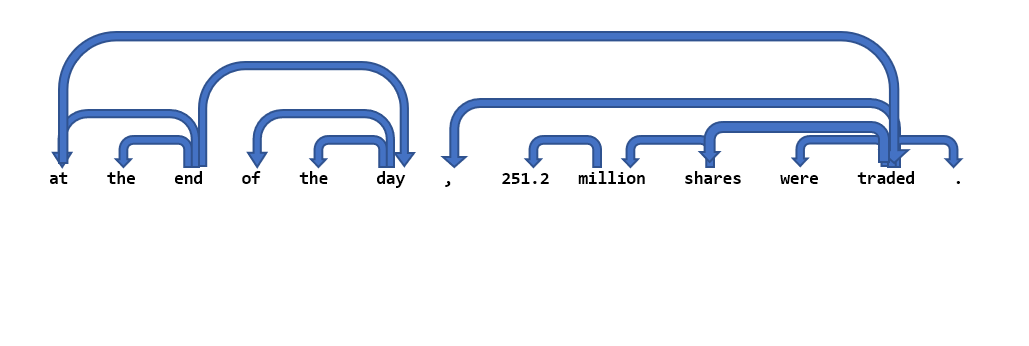

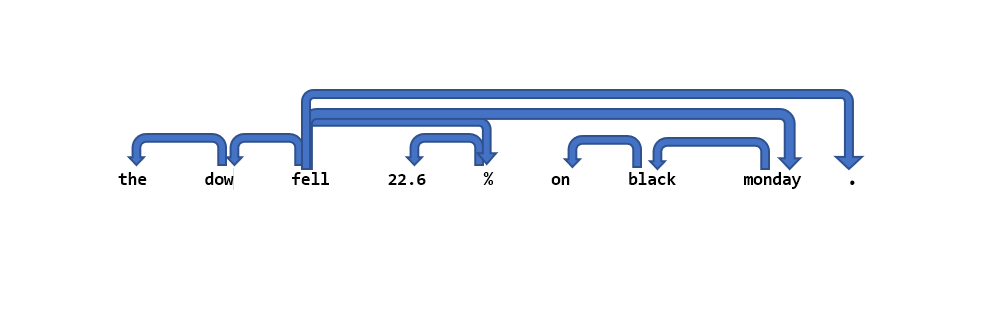

# Sumarry

## Ablation
this is the result when we try to delete some feature

|dataset| UAS (dep, pos) |  UAS (pos) | UAS (sep) |
|:-- | :--:   |  :--:          | :--:        |
|<b>dev_set| 71.48 | 71.83 |  66.72  | 
|<b>test_set| 72.56 | 74.10 |  67.62  | 

UAS score when we try to delete 12 dep features is perform best performance at 71.83 for dev_dataset and 74.10 for test_dataset

## Embedding Compare

i random choose 2 sentence and sent it to spacy model and compare with our model, as a result, our model similarity to spacy around 80 percentage